### This example shows how to optimise kernel parameters using the log marginal likelihood - a measure of how well the data is explained by the model. This script uses batch and sub-batch sampling, but not dynamic bounds reduction. It also shows in some more detail how to include Gaussian noise into the model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('..')
import BOPackage

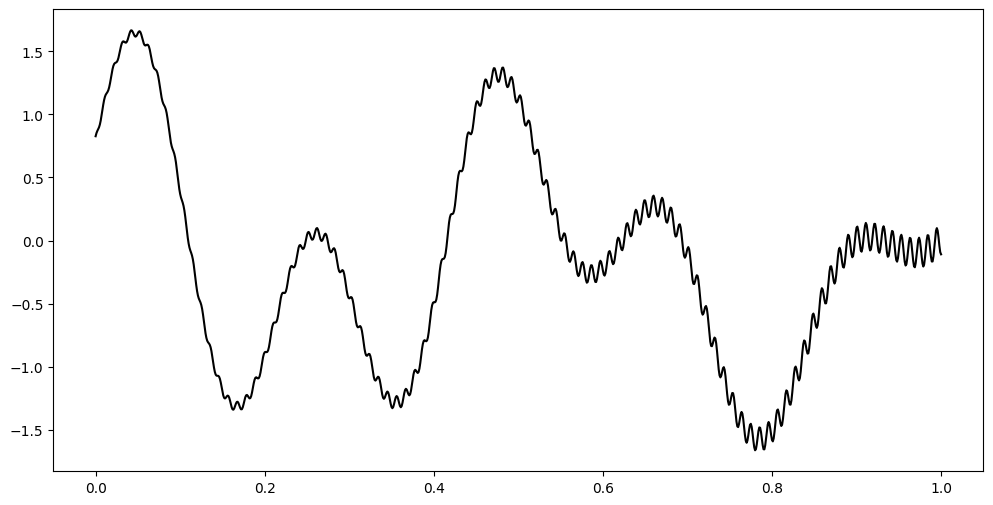

In [2]:
"""
Define the objective function. Noisy in this case (although not Gaussian noise, just a high frequency cos term). 
"""

def ObjectiveFunction(x):
    return np.sin(30*x) * np.exp(-x**2) + 0.8 * np.cos(12*x) + 0.2 * np.cos(600*x) * np.exp(-0.5*(x-2)**2) - 0.3*x


X = np.linspace(0, 1, 1001, endpoint=True).reshape(1001, 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], ObjectiveFunction(X), color='k')

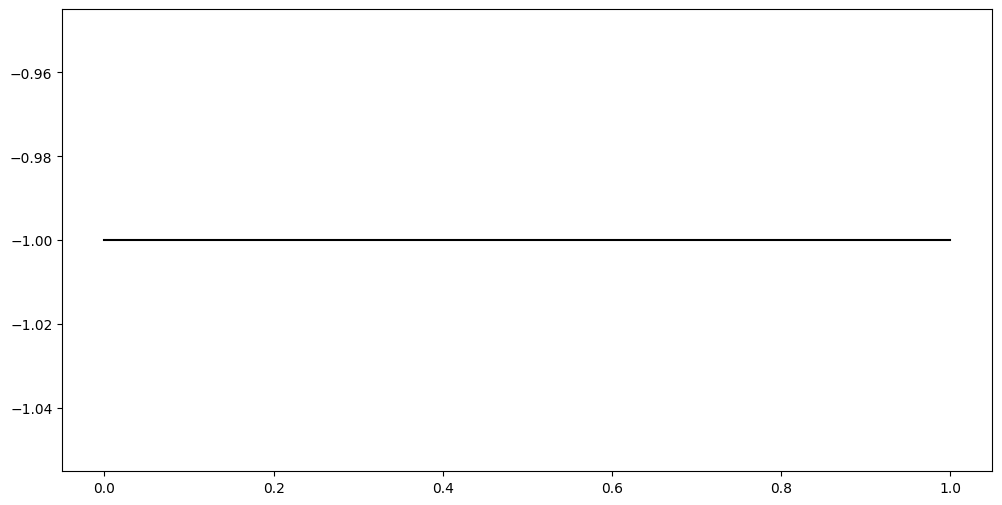

In [3]:
def PriorMeanFunction(X):
    return - np.ones(len(X)).reshape(len(X), 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], PriorMeanFunction(X), color='k')

In [ ]:
"""
Configure the optimiser Starting with a lengthscale that is clearly too large for our objective function.
"""
PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_CPU
length_scale = 0.5             # Way too large!
noise = 1e-2                    # Quite sizable noise, note throughout the images that the variance at sampled locations doesnt drop to 0.

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 100                  # Maximum kappa value used in the acquisition function for the batch
min_kappa = 0.1                 # Minimum kappa value used in the acquisition function for the batch

bounds = np.array([[0, 1]])
acquisition_samples = 10        # Number of random points in the domain to calculate the acqusition function value at. The point with the highest acquisition function value will be added to the raw_X for the batch

random_seed = None                # random seed for reproducability if wanted. 

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed,
                  noise=noise)

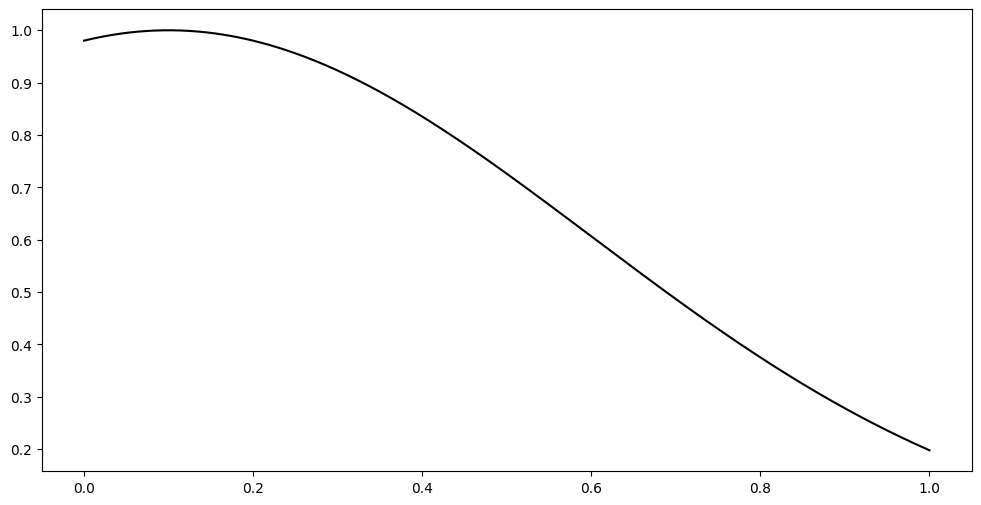

In [5]:
"""
Show the length scale currently being used. 
"""
test_X = np.array([[0.1]])
kernel_example = bo.Kernel(test_X, X, length_scales=length_scale)

plt.figure(figsize=(12, 6))

plt.plot(X, kernel_example[0, :], color='k')

In [6]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

bo.X_data, bo.y_data

(array([[0.2506401 ],
        [0.92011046],
        [0.53432953],
        [0.68384221]]),
 array([[0.05861697],
        [0.10055845],
        [0.46276755],
        [0.11553519]]))

2025-04-01 17:09:44.589844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-04-01 17:09:44.589864: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-01 17:09:44.589871: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-01 17:09:44.589901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-01 17:09:44.589918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Figure size 1200x600 with 0 Axes>

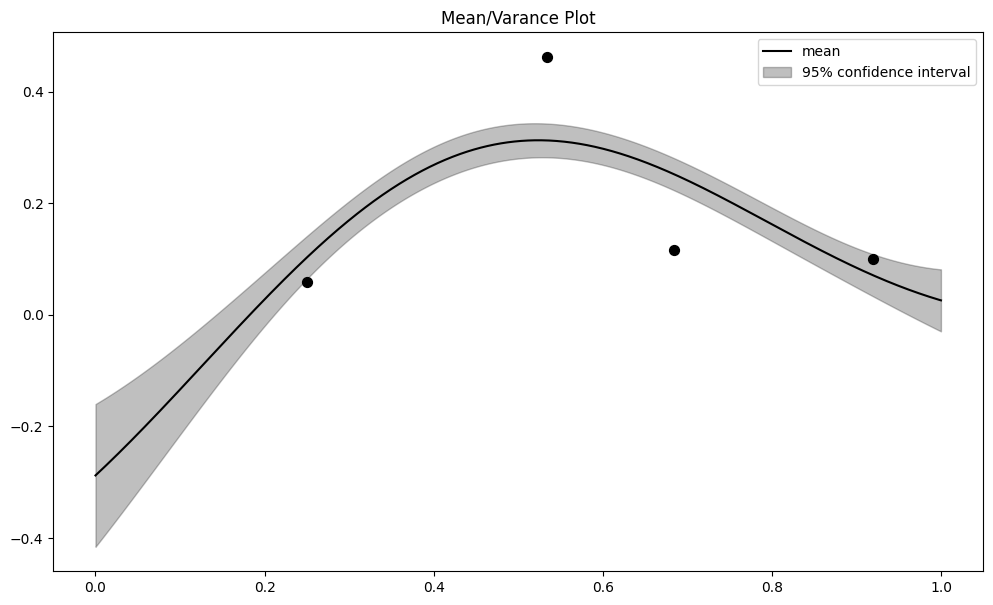

In [7]:
"""
Can then visualise the mean and variance over the parameter space. Can see that the model is struggling to fit the data with such a large length scale.
"""

BOPackage.SausagePlot(bo, normalised=False)

In [8]:
"""
We can now vary the legnthscale of the kernel function as a hyper-parameter and see which value maximises the likelihood.
This gives a good approximation for the true length scale of the function. We can use our current length scale as an initial guess.
"""

new_lengthscale = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, noise, np.array([0.5]))
print(new_lengthscale)

Optimal parameters: [0.29062074]
Function value at optimum: 2.8184937495884275
Converged: True
Number of iterations: 3
Number of function evaluations: 14
[0.29062074]


<Figure size 1200x600 with 0 Axes>

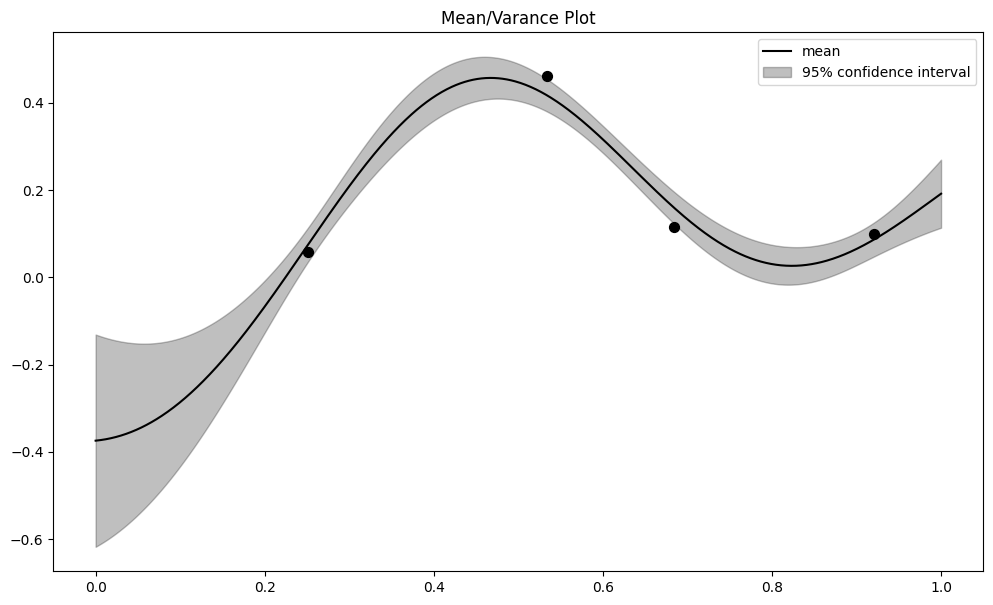

In [9]:
"""
We can now set the length scale that the model uses to the optimised lengthscale and see how the model performs now. Lets visualise the mean and variance using the optimised kernel.
"""

bo.length_scale = new_lengthscale[0]

BOPackage.SausagePlot(bo)

<Figure size 1200x600 with 0 Axes>

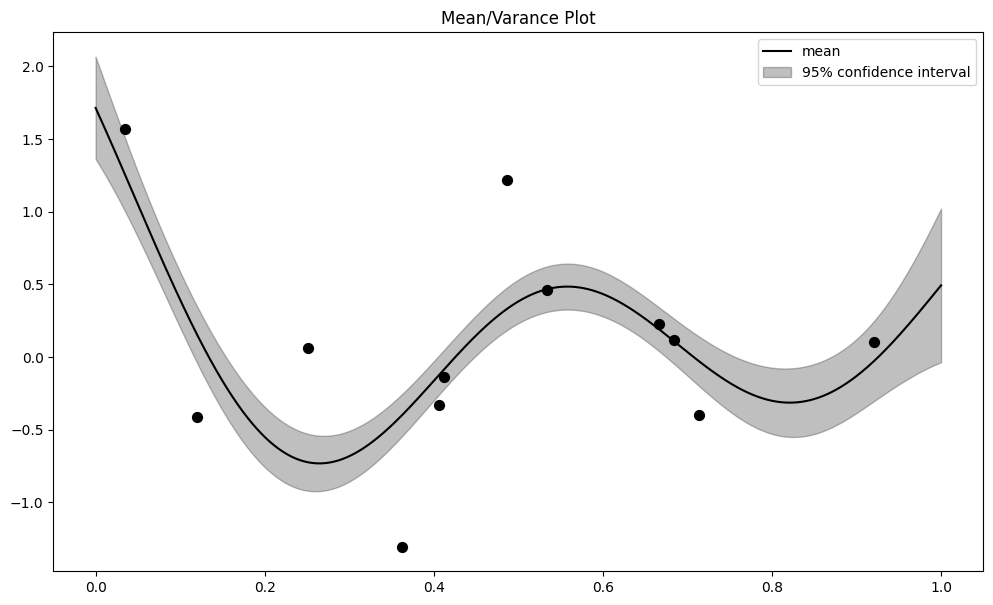

In [ ]:
"""
Lets get some more data.
"""

batch_size = 8
sub_batch_size = 4

raw_X = bo.GetNextXBatch(batch_size=batch_size, sub_batch_size=sub_batch_size, min_kappa=min_kappa, max_kappa=max_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, normalised=False)

In [ ]:
"""
Now we have more data we can see if the previous lengthscale is still optimal. (It clearly isn't and is still too large)
"""

new_lengthscale = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, noise, np.array([0.5]))
print(new_lengthscale)

Optimal parameters: [0.05611746]
Function value at optimum: 10.39319700198796
Converged: True
Number of iterations: 5
Number of function evaluations: 42
[0.05611746]


<Figure size 1200x600 with 0 Axes>

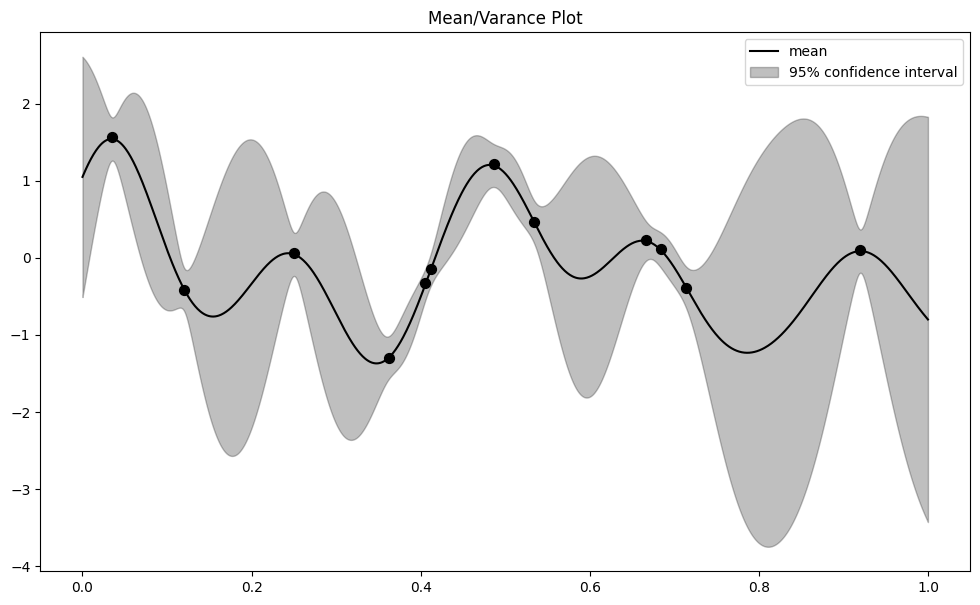

In [ ]:
"""
We can now set the length scale that the model uses to the optimised lengthscale and see how the model performs now. Lets visualise the mean and variance using the optimised kernel.
"""

bo.length_scale = new_lengthscale[0]

BOPackage.SausagePlot(bo)

<Figure size 1200x600 with 0 Axes>

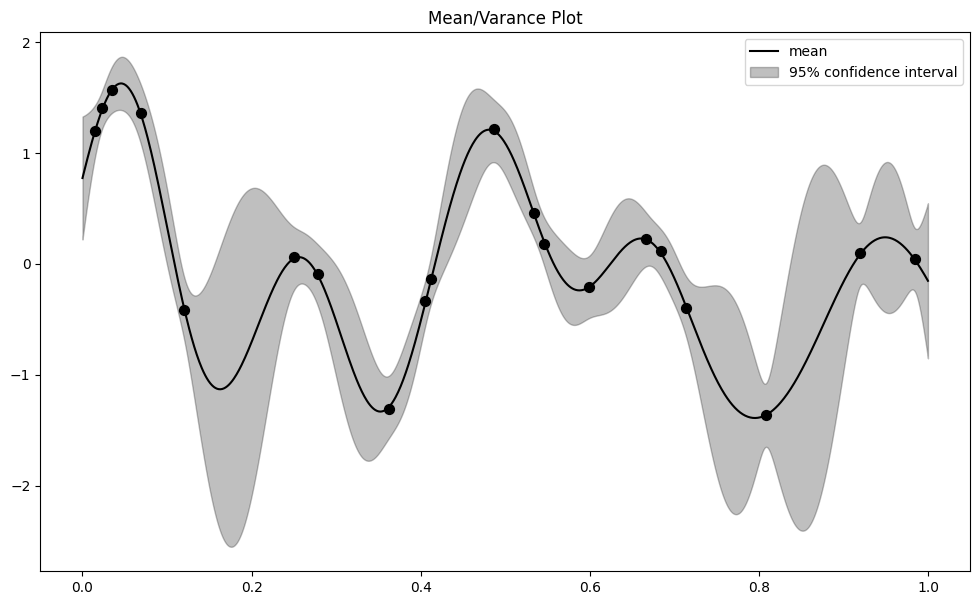

In [13]:
"""
Lets get some more data
"""

batch_size = 8
sub_batch_size = 4

raw_X = bo.GetNextXBatch(batch_size=batch_size, sub_batch_size=sub_batch_size, min_kappa=min_kappa, max_kappa=max_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, normalised=False)

In [15]:
"""
Now we have more data we can see if the previous lengthscale is still optimal. (It clearly isn't and is still too large)
"""

new_lengthscale = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, noise, np.array([0.5]))
print(new_lengthscale)

Optimal parameters: [0.06210206]
Function value at optimum: 11.228410257752186
Converged: True
Number of iterations: 9
Number of function evaluations: 30
[0.06210206]


<Figure size 1200x600 with 0 Axes>

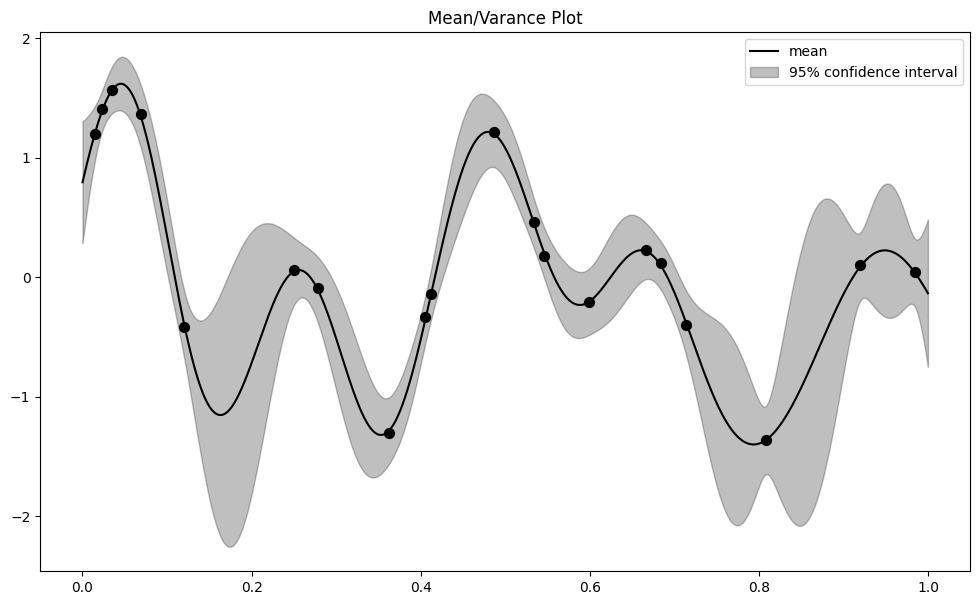

In [ ]:
"""
Lets see for a final time if we can improve our lengthscale guess. (Looks like it has roughly converged and we have a good prediction of the true underlying function.)
"""

bo.length_scale = new_lengthscale[0]

BOPackage.SausagePlot(bo)